In [1]:
# Path setup
import sys
import os

sys.path.append("/home/dchen/Random_Forest_Weights/")

# Basics:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Helpful:
from sklearn.model_selection import train_test_split

# Pipeline and ColumnsTransformer:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# models:
import statsmodels.api as sm

# my functions:
from src_rf.methods.calc_mean import *
from src_rf.methods.calc_weights import *
from src_rf.methods.calc_dist import *
from src_rf.datasets.qrf_3.load_weights_qrf_3 import * 
from src_rf.datasets.qrf_3.load_specific_weights_qrf_3 import * 
from src_rf.methods.filter_weights_rf import * 
from src_rf.methods.filter_specific_weights_rf import * 

### 0. Setup

In [2]:
dir_path = "/Data/Delong_BA_Data/rf_weights/qrf_3/"

In [3]:
batch_size = 500

### 1. Load Data, Modify and Split

In [4]:
df = pd.read_csv("/home/dchen/Random_Forest_Weights/src_rf/data/energy_data_hourly.csv"
                 , index_col = 'datetime', parse_dates=True)

df.drop(['residual_energy_usage', 'pump_storage'], inplace = True, axis =  1)
# Extract the year from the index
df['Year'] = df.index.year
# 1. Extract weekday name
df['weekday'] = df.index.day_name()

# 2. Ordinal encode 'hour', 'weekday', 'month', and 'Year'
# (In this case, 'hour', 'month', and 'Year' are already ordinal, so just encoding 'weekday')
weekday_ordering = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df['weekday'] = df['weekday'].astype(pd.CategoricalDtype(categories=weekday_ordering, ordered=True))
df['weekday'] = df['weekday'].cat.codes

# No need to change the 'Year' column as you want it in ordinal form

# 3. Add a count variable
df['Count'] = range(df.shape[0])

# Drop unnecessary columns
columns_to_drop = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
df.drop(columns=columns_to_drop, inplace=True)
    
df['Count'] = range(0, df.shape[0])

In [5]:
X = df.drop('total_energy_usage', axis = 1)
y = df['total_energy_usage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3 ,shuffle=False, random_state=42)

### 2. Load qrf_2 weights

#### 2.1 Test Date to look at

In [6]:
test_date = 10

In [7]:
qrf_3_weights = load_specific_weights_qrf_3(dir_path, test_date)

### 3. Weight Exploration

In [8]:
print(X_test.iloc[test_date, 0:][X_test.iloc[test_date, 0:] != 0])

hour           2
month          6
Year        2020
weekday        4
Count      47738
Name: 2020-06-12 02:00:00, dtype: int64


#### 3.2 Load Weights

In [9]:
qrf_3_weight_0 = filter_specific_weight_rf(qrf_3_weights , test_date, batch_size)
qrf_3_weight_0.sum()

0.9999999999999999

#### 3.3 Non-Zero Values

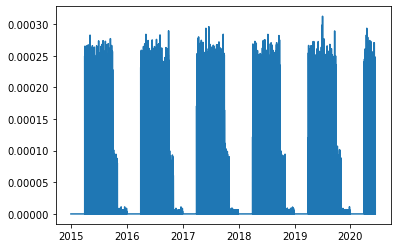

In [11]:
plt.plot(X_train.index, qrf_3_weight_0)
plt.show()

In [12]:
non_zeros =  np.where(qrf_3_weight_0 != 0)[0]

In [13]:
print('Year:')
print(X_train.iloc[non_zeros, :].index.year.value_counts().sort_values(ascending = False))
print(100 * '-')

print('Month:')
print(X_train.iloc[non_zeros, :].index.month.value_counts().sort_values(ascending = False))
print(100 * '-')

print('Week day:')
# Here, weekday gives a number where 0 is Monday and 6 is Sunday. We then map these numbers to their string names.
print(X_train.iloc[non_zeros, :].index.weekday.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
      .value_counts().sort_values(ascending = False))
print(100 * '-')

print('Hour:')
print(X_train.iloc[non_zeros, :].index.hour.value_counts().sort_values(ascending = False))

Year:
2015    1232
2016    1230
2018    1225
2019    1225
2017    1218
2020     372
Name: datetime, dtype: int64
----------------------------------------------------------------------------------------------------
Month:
5     954
4     924
6     834
8     804
10    798
7     792
9     768
12    328
11    300
Name: datetime, dtype: int64
----------------------------------------------------------------------------------------------------
Week day:
Thursday     1143
Wednesday    1137
Tuesday      1135
Friday       1125
Monday        984
Saturday      978
Name: datetime, dtype: int64
----------------------------------------------------------------------------------------------------
Hour:
0    1096
1    1086
2    1086
3    1082
4    1078
5    1074
Name: datetime, dtype: int64
